**EE677: Foundation of VLSI CAD** \\
**Course Project: Quantum Circuit Synthesis**

*Saumya Shah (22B1238) <br>
Harshil Singla (22B1260) <br>
Dattaraj Salunkhe (22B1296) <br>
Neel Rambhia (22B1298) <br>*

In [ ]:
!pip install qiskit
!pip install pylatexenc
import itertools
import pandas as pd
import random
from itertools import product
import heapq
from qiskit import QuantumCircuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=fda5d878a204d849eab7df1a4b168884507a7f73402e18204bebae4b0e101a51
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


## Part 1:
Making Truth Table reversible and expressing it's **Reed Muller Form**

In [ ]:
def make_truth_table_reversible(truth_table):
    """
    Convert a given truth table into its reversible form with minimal additional bits.

    Parameters:
    truth_table (list of tuples): Each tuple represents a row of the truth table
                                  in the format (inputs, outputs).

    Returns:
    list of tuples: A reversible truth table with a one-to-one mapping.
    """
    reversible_table = []
    input_length = len(truth_table[0][0])  # Length of input bits
    output_length = len(truth_table[0][1])  # Length of output bits

    # Group outputs and identify conflicts
    output_groups = {}
    for inputs, outputs in truth_table:
        if outputs not in output_groups:
            output_groups[outputs] = []
        output_groups[outputs].append(inputs)

    # Determine the minimum number of ancilla bits needed
    max_conflicts = max(len(inputs) for inputs in output_groups.values())
    num_ancilla_bits = (max_conflicts - 1).bit_length()  # Minimum bits to resolve conflicts

    # Generate ancilla combinations
    ancilla_values = list(itertools.product([0, 1], repeat=num_ancilla_bits))

    # Build the reversible table
    for outputs, inputs_group in output_groups.items():
        for idx, inputs in enumerate(inputs_group):
            ancilla_bits = ancilla_values[idx]
            reversible_table.append((inputs + (0,) * num_ancilla_bits, outputs + ancilla_bits))

    return reversible_table




def append_for_unique_values(truth_table):
    # Step 1: Determine the difference between the number of inputs and outputs
    max_inputs = max(len(inputs) for inputs, outputs in truth_table)
    max_outputs = max(len(outputs) if isinstance(outputs, tuple) else 1 for inputs, outputs in truth_table)
    diff = max_inputs - max_outputs

    # Step 2: Decide whether to append to inputs or outputs
    append_to = "outputs" if diff > 0 else "inputs"
    num_columns_to_add = abs(diff)

    if num_columns_to_add == 0:
        print("No need to append columns, inputs and outputs are already equal.")
        return truth_table, max_outputs

    # Step 3: Generate all possible combinations for new columns
    possible_combinations = list(product([0, 1], repeat=num_columns_to_add))
    used_combinations = set()
    total_combinations = len(possible_combinations)

    # Step 4: Append new columns to maximize unique rows
    updated_table = []
    for i, (inputs, outputs) in enumerate(truth_table):
        inputs = tuple(inputs)
        outputs = tuple(outputs if isinstance(outputs, tuple) else (outputs,))

        # Select a new combination
        for combination in possible_combinations:
            if combination not in used_combinations:
                used_combinations.add(combination)
                break
        else:
            # If all combinations are used, reuse a combination
            combination = possible_combinations[i % total_combinations]

        # Append the combination to the appropriate part (inputs or outputs)
        if append_to == "outputs":
            new_outputs = outputs + combination
            new_inputs = inputs
        else:
            new_inputs = inputs + combination
            new_outputs = outputs

        updated_table.append((new_inputs, new_outputs))

    return updated_table, max_outputs



def reduce_array(arr):
  #If terms are repeating: odd no. of terms ==> keep one copy, even no. of terms ==> remove all copies
  row_cts = {}
  for row in arr:
    row_tuple = tuple(row)
    row_cts[row_tuple] = row_cts.get(row_tuple,0) + 1

  red_arr = [list(row) for row, count in row_cts.items() if count%2 == 1]
  return red_arr



def reed_muller_form(truth_table):
    # Initialize the Reed-Muller form
    rm_form = []

    # Iterate over the outputs (second element of each pair in the truth table)
    num_outputs = len(truth_table[0][1])  # The number of output bits
    for output_index in range(num_outputs):
        # Collect input combinations for which the output is 1
        terms = []
        for inputs, outputs in truth_table:
            if outputs[output_index] == 1:
              k = list(inputs)
              zero_indices = [i for i, bit in enumerate(k) if bit == 0]

              # Generate all combinations of 0s and 1s for the zero indices
              combinations = product([0, 1], repeat=len(zero_indices))

              # Build the output by replacing 0s in the input string with each combination
              for combo in combinations:
                  result = k[:]  # Copy the original bit string
                  for idx, value in zip(zero_indices, combo):
                      result[idx] = value  # Replace 0s with the current combination
                  terms.append(result)
                  terms = reduce_array(terms)
        # If we have terms for the current output, add them to the Reed-Muller form
        if terms:
            rm_form.append(terms)
    return rm_form



def print_reed_muller_circuit(data):
  output = []
  for idx, terms in enumerate(data):
    equation = f"x{idx}t = "
    term_strings = []
    for term in terms:
      # Generate a term based on its binary representation
      sub_term = []
      for i, value in enumerate(term):
        if value == 1:
          sub_term.append(f"x{i}")
      if sub_term:
        # Join sub-term variables with a dot for AND
        term_strings.append("·".join(sub_term))
      else:
        term_strings.append("1")  # For constant terms
    # Join terms with ⊕ for XOR
    equation += " ⊕ ".join(term_strings)
    output.append(equation)
  return "\n".join(output)




def complete_truth_table(truth_table):
    # Extract all the inputs and outputs already in the table
    existing_inputs = [entry[0] for entry in truth_table]
    existing_outputs = [entry[1] for entry in truth_table]

    # Determine the number of bits based on input tuple size
    num_bits = len(existing_inputs[0])

    # Generate all possible input-output pairs (all combinations of the bits)
    all_inputs = list(itertools.product([0, 1], repeat=num_bits))
    all_outputs = list(itertools.product([0, 1], repeat=num_bits))

    # Find missing input-output pairs by checking the ones not in the existing table
    missing_inputs = set(all_inputs) - set(existing_inputs)
    missing_outputs = set(all_outputs) - set(existing_outputs)

    # If the number of missing inputs doesn't match the number of missing outputs,
    # the bijection cannot be completed
    if len(missing_inputs) != len(missing_outputs):
        raise ValueError("Cannot complete the truth table, bijection is not possible.")

    # Create a dictionary to map the missing inputs to the missing outputs
    missing_pairs = zip(missing_inputs, missing_outputs)

    # Add the missing pairs to the truth table
    completed_truth_table = truth_table + list(missing_pairs)

    return completed_truth_table

## Part 2:
Building a Quantum Circuit from the Reed Muller Form

In [ ]:
class Node:
  def __init__(self, depth, terms, pprm, elim, id, factor=None, parent=None):
    self.depth = depth
    self.terms = terms
    self.pprm = pprm
    self.elim = elim
    self.factor = factor
    self.parent = parent
    self.id = id
    self.priority = float('inf')  # Default priority

  def __lt__(self, other):
    return self.priority < other.priority


def pprm_synthesis(pprm_array, alpha, beta, gamma, time_limit, imp_bits, num_original_outputs):
  import time

  num_inputs = len(pprm_array[0][0])
  # Initialize root node
  init_terms = len(pprm_array)
  assert(num_inputs == init_terms)
  root_node = Node(
    depth=0,
    terms=init_terms,
    pprm=pprm_array,
    elim=0,
    id = 0
  )

  # Priority queue setup
  priority_queue = []
  heapq.heappush(priority_queue, (root_node.priority, root_node))

  # Best solution tracking
  best_solution = None
  best_depth = float('inf')

  # Timer
  start_time = time.time()
  id = 1
  while priority_queue and (time.time() - start_time) < time_limit:
      # Get the node with the highest priority (lowest priority value)
      _, parent_node = heapq.heappop(priority_queue)

      # Prune search tree
      if parent_node.depth >= best_depth - 1:
          continue

      parent_node_pprm = parent_node.pprm
      # Explore all output variables in the PPRM of the node
      for i in range(num_inputs):
        vi_pprm = parent_node_pprm[i]

        # Explore all factors in vi's PPRM that do not contain vi
        for factor in vi_pprm:
          vi = []
          for r in range(num_inputs):
            if(r == i):
              vi.append(1)
            else:
              vi.append(0)
          if factor[i] == 0:  # Ensure vi is not in the factor
            # Create a new child node
            child_pprm = substitute_pprm(parent_node.pprm, vi, i, factor)
            child_node = Node(
              depth=parent_node.depth + 1,
              terms=len(child_pprm),
              pprm=child_pprm,
              elim=len(parent_node_pprm[i]) - len(child_pprm[i]),
              factor=[vi]+[factor],
              parent=parent_node,
              id = id
            )
            id = id + 1

            # Check for a better solution
            identity_check = []
            for p in range(num_inputs):
              k = []
              for j in range(num_inputs):
                if(p == j):
                  k.append(1)
                else:
                  k.append(0)
              identity_check.append([k])

            arr1 = []
            arr2 = []
            for t in range(imp_bits):
              arr1.append(child_pprm[t])
              arr2.append(identity_check[t])
            if arr1 == arr2 and child_node.depth < best_depth:
              best_solution = child_node
              best_depth = child_node.depth

            # Calculate priority and add to the queue if viable
            if child_node.elim > 0:
              child_node.priority = (
                alpha * child_node.depth
                + beta * child_node.elim / child_node.depth
                - gamma * factor_literal_count(factor)
              )
              heapq.heappush(priority_queue, (child_node.priority, child_node))

  # Reconstruct the solution
  return reconstruct_solution(best_solution, num_original_outputs)


def substitute_pprm(pprm, vi, i, factor):
    """
    Substitute vi = vi ⊕ factor in all PPRM expansions.
    """
    new_pprm = []
    for term in pprm:
      new_term = []
      for sub_term in term:
        if sub_term[i] == 1:
          # XOR the factor with the term
          new_term.append(sub_term)
          extra = [1 if (t1 + t2 > 0) else 0 for t1, t2 in zip(sub_term, factor)]
          extra[i] = 0
          new_term.append(extra)
        else:
          new_term.append(sub_term)
      new_term = reduce_array(new_term)
      new_pprm.append(new_term)
    return new_pprm


def factor_literal_count(factor):
    """
    Count the number of literals in the factor.
    """
    return sum(factor)


def reconstruct_solution(node, num_original_outputs):
    """
    Reconstruct the synthesized network of Toffoli gates.
    """
    solution = []
    id = []
    while node is not None and node.factor is not None:
        solution.append(node.factor)
        id.append(node.id)
        node = node.parent
    solution.reverse()  # Reverse the order to get the top-down construction
    id.reverse()

    qc = QuantumCircuit(len(solution[0][0]), num_original_outputs)
    for t1,t2 in solution:
      i = t1.index(1)
      control_qubits = [ind for ind, value in enumerate(t2) if value == 1]
      if(len(control_qubits) == 0):
        qc.x(i)
      else:
        qc.mcx(control_qubits, i)
    qc.measure(range(num_original_outputs), range(num_original_outputs))
    return qc

The below function (**main()**) returns a Quantum Circuit based on Qiskit Framework that can be directly used for Quantum Computing Applications.

In [ ]:
def main(truth_table, alpha = 0.3, beta = 0.6, gamma = 0.1, time_limit = 10**10):
  new_truth_table, num_original_outputs = append_for_unique_values(truth_table)
  reversible_table1 = make_truth_table_reversible(new_truth_table)
  final_rev_table = complete_truth_table(reversible_table1)
  print("Reversible Truth Table:")
  for inputs, outputs in final_rev_table:
      print(f"Inputs: {inputs}, Outputs: {outputs}")
  print()

  print("Reed Muller Formulation:")
  reed_muller_ = reed_muller_form(final_rev_table)

  print(print_reed_muller_circuit(reed_muller_))
  imp_bits = num_original_outputs
  qc = pprm_synthesis(reed_muller_, alpha, beta, gamma, time_limit, imp_bits, num_original_outputs)
  display(qc.draw(output = 'mpl'))
  return qc

## Testing our **Reversible Quantum Circuit Generation Framework**

### OR Gate

Reversible Truth Table:
Inputs: (0, 0, 0), Outputs: (0, 0, 0)
Inputs: (0, 1, 0), Outputs: (1, 1, 0)
Inputs: (1, 1, 0), Outputs: (1, 1, 1)
Inputs: (1, 0, 0), Outputs: (1, 0, 0)
Inputs: (1, 0, 1), Outputs: (1, 0, 1)
Inputs: (0, 0, 1), Outputs: (0, 0, 1)
Inputs: (1, 1, 1), Outputs: (0, 1, 0)
Inputs: (0, 1, 1), Outputs: (0, 1, 1)

Reed Muller Formulation:
x0t = x1 ⊕ x1·x2 ⊕ x0 ⊕ x0·x1
x1t = x1
x2t = x0·x1 ⊕ x2


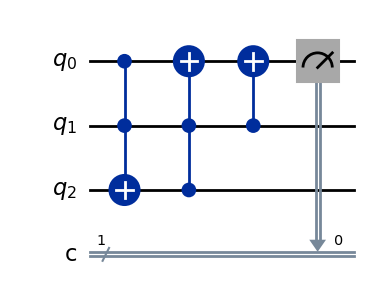

In [ ]:
truth_table = [
    ((0, 0), (0)),
    ((0, 1), (1)),
    ((1, 0), (1)),
    ((1, 1), (1))
]

qc = main(truth_table)

### AND Gate

Reversible Truth Table:
Inputs: (0, 0, 0), Outputs: (0, 0, 0)
Inputs: (1, 0, 0), Outputs: (0, 0, 1)
Inputs: (0, 1, 0), Outputs: (0, 1, 0)
Inputs: (1, 1, 0), Outputs: (1, 1, 0)
Inputs: (1, 0, 1), Outputs: (1, 0, 0)
Inputs: (0, 0, 1), Outputs: (1, 0, 1)
Inputs: (1, 1, 1), Outputs: (1, 1, 1)
Inputs: (0, 1, 1), Outputs: (0, 1, 1)

Reed Muller Formulation:
x0t = x0·x1 ⊕ x2 ⊕ x1·x2
x1t = x1
x2t = x0 ⊕ x0·x1 ⊕ x2


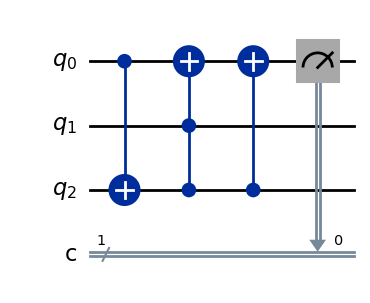

In [ ]:
truth_table = [
    ((0, 0), (0)),
    ((0, 1), (0)),
    ((1, 0), (0)),
    ((1, 1), (1))
]

qc = main(truth_table)

### Example given in the Reference Paper:

$a_0 = a \oplus 1$ <br>
$b_0 = b \oplus c \oplus ac$ <br>
$c_0 = b \oplus ab \oplus ac$

No need to append columns, inputs and outputs are already equal.
Reversible Truth Table:
Inputs: (0, 0, 0), Outputs: (0, 0, 1)
Inputs: (0, 0, 1), Outputs: (0, 0, 0)
Inputs: (0, 1, 0), Outputs: (1, 1, 1)
Inputs: (0, 1, 1), Outputs: (0, 1, 0)
Inputs: (1, 0, 0), Outputs: (0, 1, 1)
Inputs: (1, 0, 1), Outputs: (1, 0, 0)
Inputs: (1, 1, 0), Outputs: (1, 0, 1)
Inputs: (1, 1, 1), Outputs: (1, 1, 0)

Reed Muller Formulation:
x0t = x1 ⊕ x1·x2 ⊕ x0·x2
x1t = x1 ⊕ x0 ⊕ x0·x2
x2t = 1 ⊕ x2


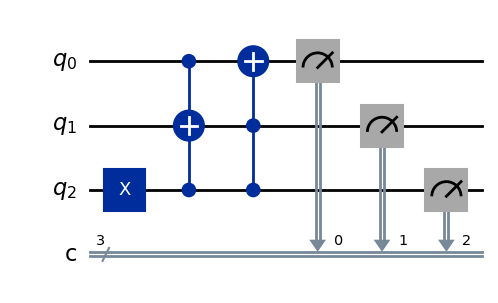

In [ ]:
truth_table = [
    ((0, 0, 0), (0, 0, 1)),
    ((0, 0, 1), (0, 0, 0)),
    ((0, 1, 0), (1, 1, 1)),
    ((0, 1, 1), (0, 1, 0)),
    ((1, 0, 0), (0, 1, 1)),
    ((1, 0, 1), (1, 0, 0)),
    ((1, 1, 0), (1, 0, 1)),
    ((1, 1, 1), (1, 1, 0)),
]

qc = main(truth_table)

### Half Adder

No need to append columns, inputs and outputs are already equal.
Reversible Truth Table:
Inputs: (0, 0, 0), Outputs: (0, 0, 0)
Inputs: (1, 0, 0), Outputs: (0, 1, 0)
Inputs: (0, 1, 0), Outputs: (0, 1, 1)
Inputs: (1, 1, 0), Outputs: (1, 0, 0)
Inputs: (1, 0, 1), Outputs: (1, 0, 1)
Inputs: (0, 0, 1), Outputs: (1, 1, 1)
Inputs: (1, 1, 1), Outputs: (1, 1, 0)
Inputs: (0, 1, 1), Outputs: (0, 0, 1)

Reed Muller Formulation:
x0t = x0·x1 ⊕ x2 ⊕ x1·x2
x1t = x0 ⊕ x1 ⊕ x2
x2t = x1 ⊕ x0·x1 ⊕ x2 ⊕ x1·x2


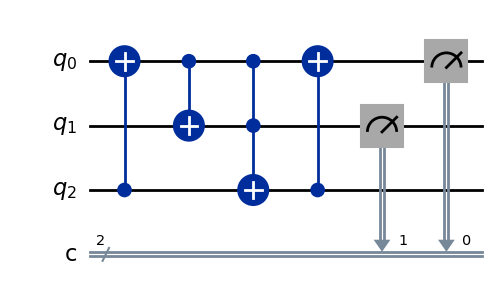

In [ ]:
truth_table = [
    ((0, 0), (0, 0)),
    ((1, 0), (0, 1)),
    ((0, 1), (0, 1)),
    ((1, 1), (1, 0)),
]

qc = main(truth_table)

### Full Adder

(Note: It might take a little time for the cell to run completely)

Reversible Truth Table:
Inputs: (0, 0, 0, 0), Outputs: (0, 0, 0, 0)
Inputs: (0, 0, 1, 0), Outputs: (0, 1, 1, 0)
Inputs: (0, 1, 0, 0), Outputs: (0, 1, 0, 0)
Inputs: (1, 0, 0, 0), Outputs: (0, 1, 0, 1)
Inputs: (0, 1, 1, 0), Outputs: (1, 0, 1, 0)
Inputs: (1, 0, 1, 0), Outputs: (1, 0, 1, 1)
Inputs: (1, 1, 0, 0), Outputs: (1, 0, 0, 0)
Inputs: (1, 1, 1, 0), Outputs: (1, 1, 1, 0)
Inputs: (0, 0, 0, 1), Outputs: (0, 0, 0, 1)
Inputs: (0, 1, 0, 1), Outputs: (0, 0, 1, 0)
Inputs: (0, 1, 1, 1), Outputs: (0, 1, 1, 1)
Inputs: (1, 0, 1, 1), Outputs: (1, 1, 0, 0)
Inputs: (1, 0, 0, 1), Outputs: (1, 0, 0, 1)
Inputs: (1, 1, 0, 1), Outputs: (1, 1, 0, 1)
Inputs: (0, 0, 1, 1), Outputs: (0, 0, 1, 1)
Inputs: (1, 1, 1, 1), Outputs: (1, 1, 1, 1)

Reed Muller Formulation:
x0t = x1·x2 ⊕ x1·x2·x3 ⊕ x0·x2 ⊕ x0·x1 ⊕ x0·x3 ⊕ x0·x2·x3 ⊕ x0·x1·x3
x1t = x2 ⊕ x2·x3 ⊕ x1 ⊕ x1·x3 ⊕ x0 ⊕ x0·x3 ⊕ x1·x2·x3 ⊕ x0·x2·x3 ⊕ x0·x1·x3
x2t = x2 ⊕ x1·x3 ⊕ x0·x1·x3 ⊕ x1·x2·x3 ⊕ x0·x2·x3
x3t = x0 ⊕ x0·x1 ⊕ x3 ⊕ x1·x3 ⊕ x0·x3 ⊕ x1·x2·x3 ⊕ 

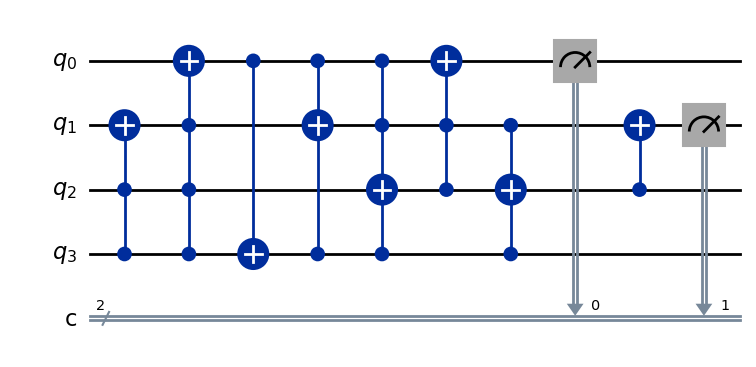

In [ ]:
truth_table = [
    ((0, 0, 0), (0, 0)),
    ((0, 0, 1), (0, 1)),
    ((0, 1, 0), (0, 1)),
    ((0, 1, 1), (1, 0)),
    ((1, 0, 0), (0, 1)),
    ((1, 0, 1), (1, 0)),
    ((1, 1, 0), (1, 0)),
    ((1, 1, 1), (1, 1)),
]

qc = main(truth_table)